In [1]:
# mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install kaggle
!pip install -q kaggle

In [3]:
# configure the kaggle API access
# create a directory for kaggle in the Colab environment
# copy the kaggle.json file from the Google Drive
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [4]:
# set permission to the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download the dataset using the kaggle API command
!kaggle datasets download tanshihjen/octdl-oct-dataset

Dataset URL: https://www.kaggle.com/datasets/tanshihjen/octdl-oct-dataset
License(s): unknown
 98% 371M/380M [00:02<00:00, 186MB/s]
100% 380M/380M [00:02<00:00, 166MB/s]


In [6]:
# unzip the download dataset
!unzip octdl-oct-dataset.zip

Archive:  octdl-oct-dataset.zip
  inflating: OCTDL/AMD/amd_1047099_1.jpg  
  inflating: OCTDL/AMD/amd_1047099_2.jpg  
  inflating: OCTDL/AMD/amd_1047099_3.jpg  
  inflating: OCTDL/AMD/amd_1047099_4.jpg  
  inflating: OCTDL/AMD/amd_1084498_1.jpg  
  inflating: OCTDL/AMD/amd_1084498_2.jpg  
  inflating: OCTDL/AMD/amd_1084498_3.jpg  
  inflating: OCTDL/AMD/amd_1096590_1.jpg  
  inflating: OCTDL/AMD/amd_1096590_2.jpg  
  inflating: OCTDL/AMD/amd_1096590_3.jpg  
  inflating: OCTDL/AMD/amd_1096590_4.jpg  
  inflating: OCTDL/AMD/amd_1096590_5.jpg  
  inflating: OCTDL/AMD/amd_1101816_1.jpg  
  inflating: OCTDL/AMD/amd_1101816_2.jpg  
  inflating: OCTDL/AMD/amd_1101816_3.jpg  
  inflating: OCTDL/AMD/amd_1101816_4.jpg  
  inflating: OCTDL/AMD/amd_1131743_1.jpg  
  inflating: OCTDL/AMD/amd_1163930_1.jpg  
  inflating: OCTDL/AMD/amd_1163930_2.jpg  
  inflating: OCTDL/AMD/amd_1163930_3.jpg  
  inflating: OCTDL/AMD/amd_1168623_1.jpg  
  inflating: OCTDL/AMD/amd_1168623_2.jpg  
  inflating: OCTDL/AMD

In [7]:
# import essential libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

In [ ]:
# specified the data directory
data_dr = '/content/OCTDL'

In [ ]:
# create dataframe for the data
path_col = []
label_col = []
imagename_col = []

folders = os.listdir(data_dr)
for folder in folders:
  folder_path = os.path.join(data_dr, folder)
  files = os.listdir(folder_path)
  for file in files:
    img_path = os.path.join(folder_path, file)
    if img_path.lower().endswith(('.png','.jpg','.jpeg')):
      imagename_col.append(file.split('.')[0])
      path_col.append(img_path)
      label_col.append(folder)

image_df = pd.DataFrame({'Path':path_col, 'Label':label_col, 'file_name':imagename_col})

# check the dimension of the dataset
print('Dimension of the dataset:', image_df.shape)

# display the first 5 rows of the dataset
display(image_df.head(n=5))

Dimension of the dataset: (2064, 3)


,Path,Label,file_name
0,/content/OCTDL/NO/no_9663705_1.jpg,NO,no_9663705_1
1,/content/OCTDL/NO/no_8617991_1.jpg,NO,no_8617991_1
2,/content/OCTDL/NO/no_4478714_1.jpg,NO,no_4478714_1
3,/content/OCTDL/NO/no_7860459_5.jpg,NO,no_7860459_5
4,/content/OCTDL/NO/no_4478714_2.jpg,NO,no_4478714_2


In [ ]:
# read the label dataset
label_df = pd.read_csv('/content/drive/MyDrive/dataset/OCTDL_labels.csv')

# merge the image_df and label_df
merged_df = pd.merge(image_df, label_df[['file_name','disease','patient_id']], on='file_name', how='left')

In [ ]:
# remove the duplicate patient_id
patient_df = merged_df[['disease','patient_id']]
patient_df = patient_df.drop_duplicates()

In [ ]:
# split the dataset into train, test, and validation
from sklearn.model_selection import train_test_split

train, X = train_test_split(patient_df, test_size=0.3, shuffle=True, stratify=patient_df['disease'], random_state=122)
test, val = train_test_split(X, test_size=0.3, shuffle=True, stratify=X['disease'], random_state=122)

# get the list of the patient_id in train, test, and validation
train_patient = train['patient_id'].unique()
test_patient = test['patient_id'].unique()
val_patient = val['patient_id'].unique()

In [ ]:
# helper function to assign the train, tets and validation label to the dataset
def check_data(x):
  if x in train_patient:
    return 'train'
  elif x in test_patient:
    return 'test'
  elif x in val_patient:
    return 'val'

In [ ]:
# insert a new column with the category of the dataset
merged_df['dataset'] = merged_df['patient_id'].apply(check_data)

train_df = merged_df[merged_df['dataset']=='train']
test_df = merged_df[merged_df['dataset']=='test']
val_df = merged_df[merged_df['dataset']=='val']

train_df = train_df[['Path','Label']]
test_df = test_df[['Path','Label']]
val_df = val_df[['Path','Label']]

# reset index for each dataset
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

print('Dimension of train dataset:', train_df.shape)
print('Dimension of test dataset:', test_df.shape)
print('Dimension of validation dataset:', val_df.shape)

Dimension of train dataset: (1454, 2)
Dimension of test dataset: (407, 2)
Dimension of validation dataset: (203, 2)


In [ ]:
# export the train, test, and validation datasets
train_df.to_csv('/content/drive/MyDrive/dataset/oct_train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/dataset/oct_test.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/dataset/oct_val.csv', index=False)

In [8]:
train_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_val.csv')

In [10]:
# number of classes in the dataset
print('Number of classes in the dataset:', train_df.Label.nunique())
print('Classes in the dataset:', train_df.Label.unique())

Number of classes in the dataset: 7
Classes in the dataset: ['NO' 'DME' 'RAO' 'VID' 'AMD' 'RVO' 'ERM']


In [ ]:
# compute the class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['Label'].unique()), y=train_df['Label'])
class_weights_dict = dict(zip(np.unique(train_df['Label'].unique()), np.round(class_weights,4)))
print(class_weights_dict)

{'AMD': 0.2401, 'DME': 1.9973, 'ERM': 1.9056, 'NO': 0.8992, 'RAO': 11.5397, 'RVO': 2.8454, 'VID': 3.8466}


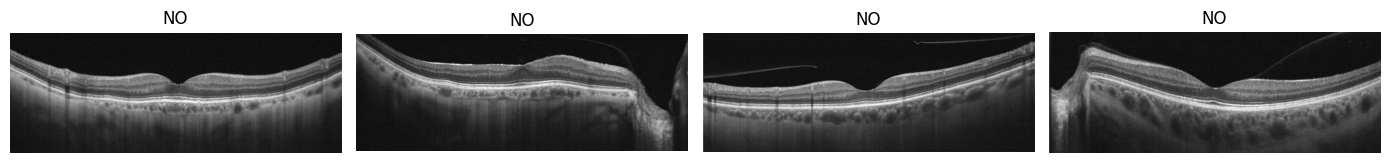

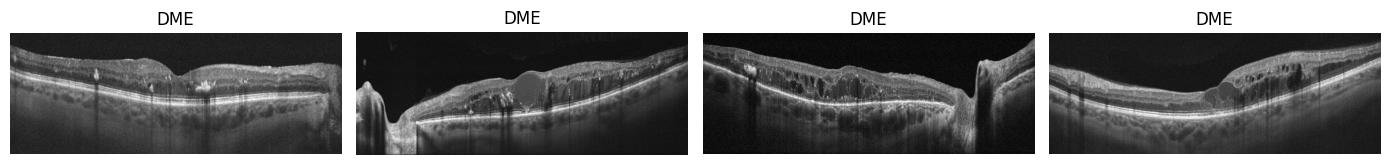

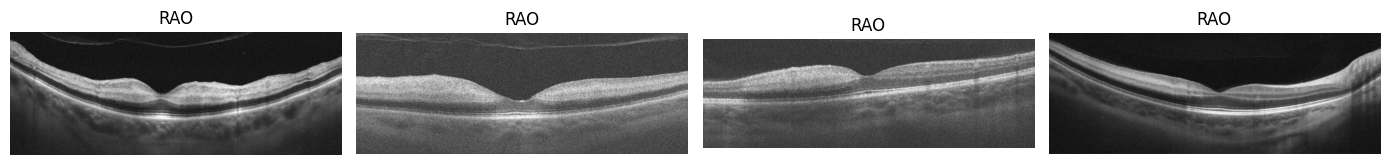

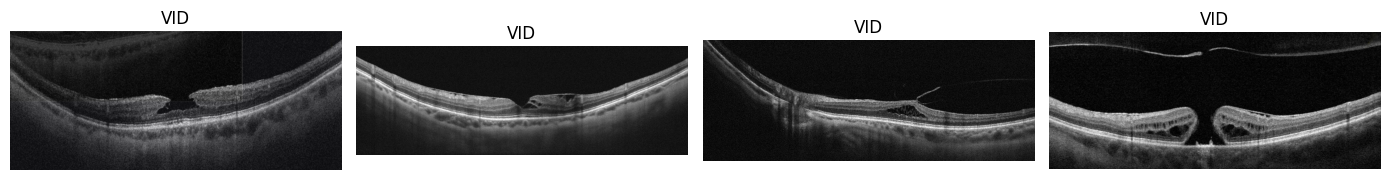

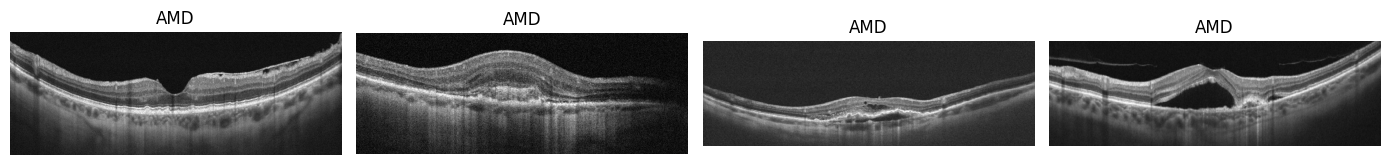

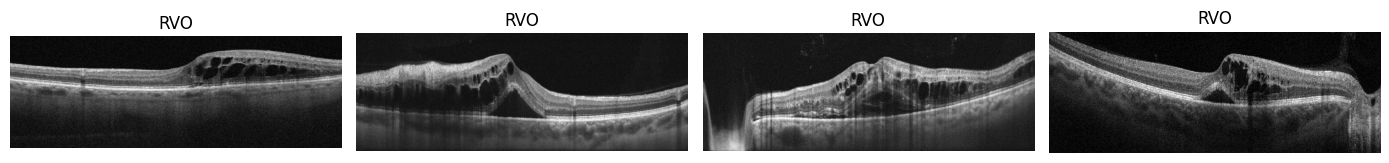

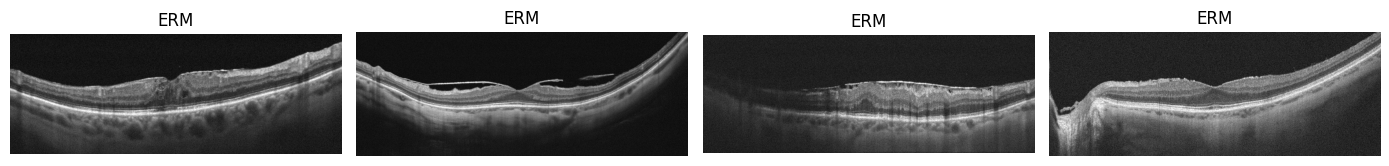

In [ ]:
# visualize example images from each class
for cls in train_df.Label.unique():
  df_selected = train_df[train_df.Label == cls]
  df_subset = df_selected.sample(n=4, random_state=122)
  plt.figure(figsize=(14,2))
  for i, path in zip(range(len(df_subset)), df_subset.Path):
    plt.subplot(1,4,i+1)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.title(cls)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function = None,
    rotation_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.0,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

val_datagen = ImageDataGenerator(preprocessing_function=None)

In [27]:
# prepare the dataset
train_ds = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = True,
    seed = 122,
)

val_ds = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = False
)

Found 1454 validated image filenames belonging to 7 classes.
Found 203 validated image filenames belonging to 7 classes.


In [28]:
test_df = pd.read_csv('/content/drive/MyDrive/dataset/oct_test.csv')

test_datagen = ImageDataGenerator(preprocessing_function=None)

test_ds = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = None,
    x_col = 'Path',
    y_col = 'Label',
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (224, 224),
    shuffle = False
)

Found 407 validated image filenames belonging to 7 classes.


In [29]:
# define list of callbacks to enhance model training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/models/oct_enetv2m_sp_151124.keras', save_best_only=True),
    keras.callbacks.CSVLogger(filename='/content/drive/MyDrive/learning_history/oct_enetv2m_sp_151124.csv'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=0.00001)
    ]

In [30]:
# metrics to be used for compiling the model
metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

In [31]:
from keras.applications import EfficientNetV2M

# helper function to define the neural network on top of the pre-trained model
def tf_model():
  input_shape = (224, 224, 3)

  inputs = keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  base_model = EfficientNetV2M(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape,
    pooling = 'avg'
)

  base_model.trainable = True

  x = base_model(x)

  x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
  x = layers.Dense(units=256, activation='relu')(x)
  x = layers.Dense(units=128, activation='relu')(x)
  x = layers.Dropout(rate=0.25, seed=122)(x)
  output = layers.Dense(units=7, activation='softmax')(x)

  model = keras.models.Model(inputs=inputs, outputs=output)

  model.compile(optimizer = keras.optimizers.Adamax(learning_rate=0.001),
                loss = keras.losses.categorical_crossentropy,
                metrics = metrics
                )

  return model

In [32]:
enetv2m_sp_151124 = tf_model()

In [33]:
history = enetv2m_sp_151124.fit(train_ds,
                                epochs = 100,
                                validation_data = val_ds,
                                callbacks = callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 393s 4s/step - auc: 0.7852 - categorical_accuracy: 0.5257 - loss: 1.6357 - precision: 0.6216 - recall: 0.4115 - val_auc: 0.9074 - val_categorical_accuracy: 0.6552 - val_loss: 1.6182 - val_precision: 1.0000 - val_recall: 0.0049 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 725ms/step - auc: 0.9248 - categorical_accuracy: 0.6891 - loss: 0.9436 - precision: 0.8089 - recall: 0.5991 - val_auc: 0.9088 - val_categorical_accuracy: 0.6798 - val_loss: 1.4318 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 723ms/step - auc: 0.9553 - categorical_accuracy: 0.7632 - loss: 0.7178 - precision: 0.8459 - recall: 0.6657 - val_auc: 0.9767 - val_categorical_accuracy: 0.8473 - val_loss: 0.6843 - val_precision: 0.9704 - val_recall: 0.6453 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 728ms/step - auc: 0.9752 - categorical_accuracy: 0.8151 - loss: 0.5242 - precision: 0.8

In [34]:
enetv2m_sp_151124.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,962,547 (610.21 MB)

 Trainable params: 53,222,651 (203.03 MB)

 Non-trainable params: 294,592 (1.12 MB)

 Optimizer params: 106,445,304 (406.06 MB)

In [35]:
# export the trained model
enetv2m_sp_151124.save('/content/drive/MyDrive/models/enetv2m_sp_151124.h5')

In [36]:
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/models/oct_enetv2m_sp_151124.keras')

In [37]:
# check the model performance on test dataset
res = enetv2m_sp_151124.evaluate(test_ds)
print(round(res[1]*100,2),'%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - auc: 0.9950 - categorical_accuracy: 0.9169 - loss: 0.2289 - precision: 0.9297 - recall: 0.9049
90.91 %


In [38]:
res = saved_model.evaluate(test_ds)
print(round(res[1]*100,2),'%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 828ms/step - auc: 0.9950 - categorical_accuracy: 0.9169 - loss: 0.2289 - precision: 0.9297 - recall: 0.9049
90.91 %


In [39]:
# probabilities and predicted class for the test dataset
ypred_proba = enetv2m_sp_151124.predict(test_ds)
ypred = np.argmax(ypred_proba, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [40]:
# classification report
from sklearn.metrics import classification_report

# the actual class label (ytrue)
y = test_ds.classes

# the classes
label_classes = test_ds.class_indices.keys()

report_enet = classification_report(y, ypred, target_names=label_classes)
print(report_enet)

              precision    recall  f1-score   support

         AMD       0.97      0.97      0.97       238
         DME       0.65      0.69      0.67        29
         ERM       0.83      0.97      0.89        30
          NO       0.88      0.94      0.91        68
         RAO       1.00      1.00      1.00         3
         RVO       0.75      0.39      0.51        23
         VID       0.94      0.94      0.94        16

    accuracy                           0.91       407
   macro avg       0.86      0.84      0.84       407
weighted avg       0.91      0.91      0.90       407



In [25]:
# classification report
from sklearn.metrics import classification_report

# the actual class label (ytrue)
y = test_ds.classes

# the classes
label_classes = test_ds.class_indices.keys()

report_enet = classification_report(y, ypred, target_names=label_classes)
print(report_enet)

              precision    recall  f1-score   support

         AMD       0.96      0.95      0.96       238
         DME       0.60      0.83      0.70        29
         ERM       0.77      0.90      0.83        30
          NO       0.87      0.90      0.88        68
         RAO       1.00      0.67      0.80         3
         RVO       0.78      0.30      0.44        23
         VID       0.80      0.75      0.77        16

    accuracy                           0.88       407
   macro avg       0.83      0.76      0.77       407
weighted avg       0.89      0.88      0.88       407



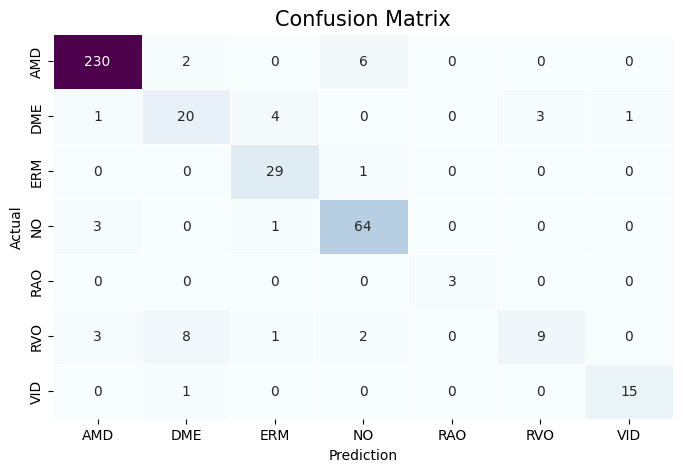

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, ypred)

# visualize the confusion matrix in heatmap
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='.4g', cbar=False, cmap='BuPu', xticklabels=label_classes, yticklabels=label_classes, linewidth=0.5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix', fontsize=15)
plt.show()